### Instrucciones generales <a class="tocSkip"></a>

1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)



# Tarea 2: Filtrado de señales

## Introducción


Un **electrocardiograma (ECG)** es un gráfico de voltaje (amplitud) en función del tiempo correspondiente a la actividad eléctrica del corazón. Cada etapa del ciclo cardíaco es representado por una letra: **P, Q, R, S y T**. La siguiente figura muestra un esquema de un ECG con dos pulsos.

<img src="cardio.png" width="600">


El ECG se usa para hacer diagnósticos y en particular para analizar la existencia de anormalidades en el ciclo cardiaco. La **frecuencia cardiaca**, es decir el inverso del intervalo RR, de un humano normal en reposo está en el rango de **60 y 100 latidos por minuto**



## Enunciado

El hospital base de Valdivia tiene un electrocardiógrafo que mide la ECG en miliVolts [mV] a una frecuencia de muestreo de $360$ [Hz]

Durante el proceso de captura ciertos errores provocaron que la señal se contamine con 

- **(A)** Un ruido asociado al sistema eléctrico
- **(B)** Un ruido de baja frecuencia causado por un desperfecto del sensor
- **(C)** Un ruido blanco de origen térmico 

Esto complica el análisis del médico por lo que el hospital base los contrata a ustedes para **diseñar un filtro que limpie la señal ECG**

Resuelva las actividades que se piden a continuación, respondiendo y analizando donde corresponda

Loading BokehJS ...

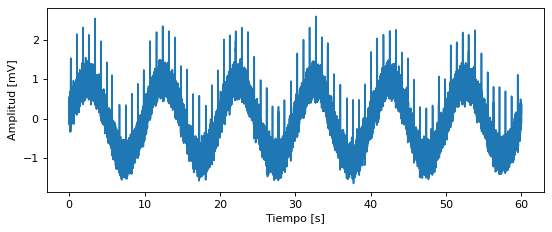

In [3]:
import numpy as np
import pickle
%matplotlib notebook
import scipy.signal
import scipy.fft as sfft
import matplotlib.pylab as plt
from bokeh.layouts import column, row
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.plotting import Figure, show, output_notebook
output_notebook()

from bokeh.palettes import Dark2_5 as palette
%matplotlib inline

from matplotlib import animation, patches, rc
import ipywidgets as widgets
import matplotlib as mpl
rc('animation', html='html5')
rc('savefig', dpi=80)
rc('figure', dpi=80)
from IPython.display import YouTubeVideo, HTML, Audio

with open("ECG.pkl", "rb") as f:
    data = pickle.load(f)

Fs = 360
time = np.arange(len(data))/Fs
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.plot(time, data)
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Amplitud [mV]');


## Análisis (15%)

- Observe los primeros dos segundos de la señal, compare con el esquema mostrado en la introducción y discuta sobre los efectos causados por los ruidos **A**, **B** y **C** mencionados en el enunciado. Además responda  ¿Qué es un ruido blanco y que tipo de efecto introduce en la señal y en su espectro? ¿Qué es una tendencia y que tipo de efecto introduce en la señal y su espectro? 
- Calcule y muestre gráficamente el valor absoluto de la transformada de Fourier de la señal en función de la frecuencia y su espectrograma en función del tiempo y la frecuencia. Para el espectrograma decida el largo de ventana, traslape y tipo de ventana. Justifique su elección tomando en consideración el rango de frecuencias de un paciente normal y los *trade-off* aprendidos en clases
- En base a la señal, su espectro de magnitud y su espectrograma identifique la frecuencia central o el rango de frecuencias asociada a las tres fuentes de ruido. ¿En qué rango de frecuencias (Hz) se espera encontrar la señal de ritmo cardíaco de un humano normal en reposo?


## Respuestas

**Apreciaciones generales** : Dentro de toda la señal lo más notorio son los complejos QRS (Despolarización Ventricular)

**Ruido Blanco** : El ruido blanco es una señal en que sus frecuencias son de potencia constante, se presenta de forma infinita y con variaciones de amplitud.

**Tendencia** : En este caso una tendencia es una inclinación en el comportamiento de la señal. Dentro de la señal presentada anteriormente, claramente podemos ver que mantiene una tendencia sinusoidal.

- **Ruido A** : Este ruido eléctrico que se suma a la señal original, porque es un ruido aditivo, es el que hace que pierda "suavidad" la señal, si bien no es tan notorio, ya que creemos que se ve opacado por el ruido blanco, podemos notarlo en los complejos QRS apreciados dentro de los dos segundos, el cual les suma unas "imperfecciones" extras.
- **Ruido B** : Este ruido de baja frecuencia que se suma a la señal original, ya que es un ruido aditivo, es el que hace que la señal vaya tomando la forma sinusoidal vista en la señal en su totalidad, dentro de los dos segundos, es el que hace que vaya creciendo, en vez de mantenerse lineal.
- **Ruido C** : Este ruido blanco es el que se ve presente dentro de toda la seña y nos hace perder la visibilidad del ECG sin dejarnos distinguir los puntos S y T, por ejemplo. Con este ruido solamente podemos llegar a obviar donde se encuentran nuestros complejos QRS, que en este caso serían 3 dentro de los 2 segundos observados.

## Transformada de Fourier

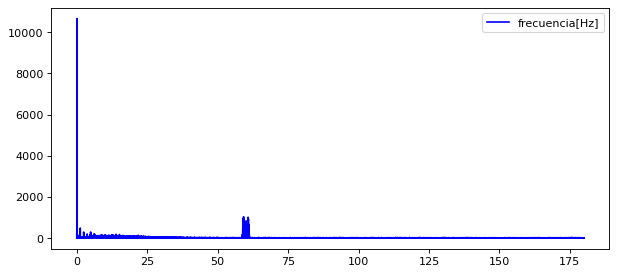

In [22]:
N = len(data)

fr = sfft.rfftfreq(n=N, d=1./Fs)
S = np.absolute(sfft.rfft(data))

plt.figure(figsize=(9,4))
plt.plot(fr, S, 'b-')
plt.legend(('frecuencia[Hz]', 'S'))
plt.show()

## Espectrograma

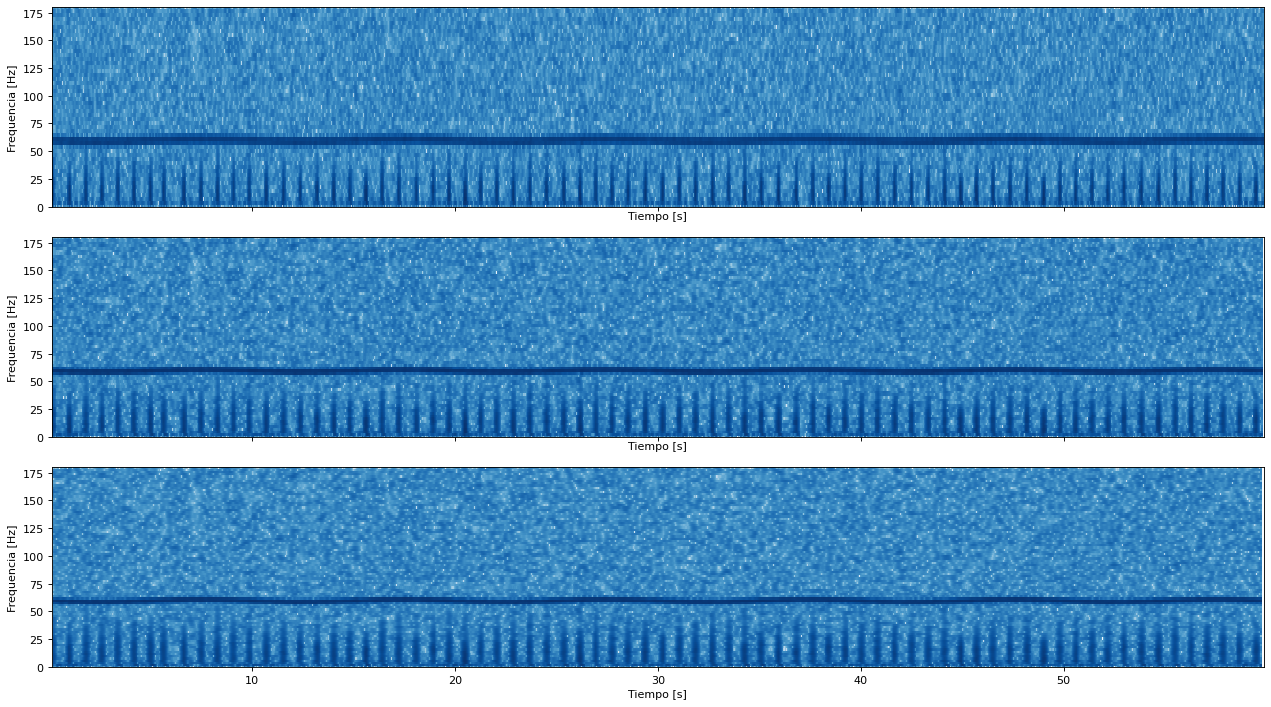

In [5]:
beta = 5. #que sea parecido a un coseno
fig, axs = plt.subplots(3, 1, figsize=(16, 9), tight_layout=True, sharex=True, sharey=True)

#queremos probar en diferentes tamaños de ventana para sacar el valor que más nos sirve
for axs, Nw in zip(axs, [100, 150, 180]):
    freqs, times, Sxx = scipy.signal.spectrogram(data, fs=Fs, window=('kaiser', beta), nperseg=Nw, noverlap=Nw//1.1)
    axs.pcolormesh(times, freqs, np.log10(Sxx+1e-10), cmap=plt.cm.Blues, shading='auto');
    axs.set_ylabel('Frequencia [Hz]');
    axs.set_xlabel('Tiempo [s]'); 
    axs.set_ylim([0, 180]);


## Consideraciones

+ **Tipo de Ventana** : Escogimos la Kaiser, pero con un beta de 5. que se usa para el cosino. Esto más que nada lo escogimos por el tipo de señal que se muestra inicialmente.
+ **Tamaño de Ventana** : El tamaño de ventana, fue escogido investigando un poco sobre el funcionamiento de un electrocardiograma y sobre los rangos de frecuencia donde se suele ver la información más importante.
+ **Tamaño de Traslape** : El traslape lo escogimos, ya que la "distancia" entre latidos debería ser bien pequeña.

## Respuestas

+ Nuestro **Ruido Blanco** se encuentra en todo el espectrograma, hasta los 180 [Hz] aproximadamente.
+ Nuestro **Ruido Eléctrico** se encuentra aproximadamente entre un rango de 0 a 50 [Hz].
+ Nuestro **Ruido de Baja** Frecuencia se encuentra en la vecindad de los 60 [Hz].

*La señal de ritmo cardiaco de un humano normal en reposo, se debería encontrar en un rango de frecuencias entre 0 y 10 [Hz], pero a la vez también se puede encontrar información importante debajo de los 100 [Hz]*

## Filtrado FIR (50%)

Describa lo que es un filtro FIR, explique paso a paso el método de enventanado y describa los argumentos y el valor de retorno de la función `scipy.signal.firwin`. 

Luego use este método para diseñar y aplicar tres filtros sobre la señal de entrada. El primero debe filtrar el ruido **(A)**, el segundo el ruido **(B)** y el tercero el ruido **(C)**. Indique la(s) frecuencia(s) de corte y el tipo de filtro en cada caso. Justifique su elección en base a sus observaciones en el paso anterior.

Considere una ventana de Hamming y $1001$ coeficientes para el filtro

Por cada filtro:
- Muestre la respuesta al impulso y la respuesta en frecuencia resultantes
- Filtre la señal convolucionando con la respuesta al impulso
- Calcule la resta entre la señal original y la señal filtrada. ¿Qué espera observar en este caso? Luego muestre gráficamente el espectro de magnitud y el espectrograma de la señal restada. En base a lo que observa y a los gráficos del punto anterior discuta sobre la efectividad del filtro

Finalmente
- Filtre la señal convolucionando con los tres filtros. Muestre el resultado graficamente. 
- Muestre un acercamiento de los primeros tres segundos de la señal filtrada, reconozca la fase R y márquela con una linea roja punteada.
- Cree una función que mida el tiempo RR en la señal filtrada. Grafique la frecuencia cardiaca en función del tiempo. ¿Se encuentra la persona en el rango sano o no?

## Descripciones

**¿Qué es un filtro FIR?**
- Un filtro FIR (Finite Impulse Response) es un sistema de filtro digital lineal no recursivo, el cual suele ser estable pero no eficiente. Este en respuesta a una señal (impulso), da un número finito de valores no nulos, que suelen ser los coeficientes.

**Función scipy.signal.firwin**

***MÉTODO***
- asAS

***ARGUMENTOS***
- numtaps, # (entero) Largo del filtro
- cutoff, # Frecuencia de corte: Una para pasa bajo/alto o dos para pasa/rechaza banda
- window='hamming', # Tipo de ventana
- pass_zero=True, # pasa bajo (True) o pasa alto (False)
- fs=None # Frecuencia de muestreo

***RETORNO***
- Coeficientes de longitud numtaps del filtro FIR o la respuesta al impulso del filtro FIR.

## Ruido 1

In [160]:
co = 1001 #cantidad de coeficientes

fc1 = 50 #frecuencia de corte ruido 1

p = [Figure(plot_width=600, plot_height=200, toolbar_location="below") for k1 in range(2)]

#filtro FIR para el Ruido 1
h1 = scipy.signal.firwin(numtaps=co, cutoff=fc1, pass_zero=True, window='hamming',fs=Fs)
conv1 = scipy.signal.convolve(data, h1, mode='same', method='auto')
signal1 = data - conv1

freq_fir1, response_fir1 = scipy.signal.freqz(h1, 1, fs=Fs)
freq_fir1, delay_fir1 = scipy.signal.group_delay(system=(h1, 1), fs=Fs)

p[0].line(freq_fir1, np.absolute(response_fir1), color=palette[0], line_width=3, legend_label="FIR RUIDO 1"); 
p[1].line(freq_fir1, delay_fir1, color=palette[0], line_width=3, legend_label="FIR RUIDO 1");

p[1].xaxis.axis_label = 'Frecuencia [Hz]'
p[0].yaxis.axis_label = '|H|'
p[1].yaxis.axis_label = 'Desfase [º]'

show(column(p))

### ¿Qué pretendemos observar?

## Fourier sin Ruido 1

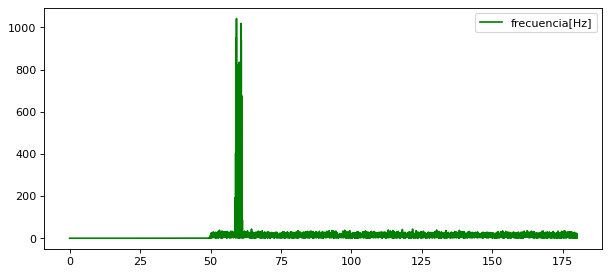

In [161]:
N1 = len(signal1)

fr1 = sfft.rfftfreq(n=N1, d=1./Fs)
S1 = np.absolute(sfft.rfft(signal1))

plt.figure(figsize=(9,4))
plt.plot(fr1, S1, 'g-')
plt.legend(('frecuencia[Hz]', 'S'))
plt.show()

## Espectrograma sin Ruido 1

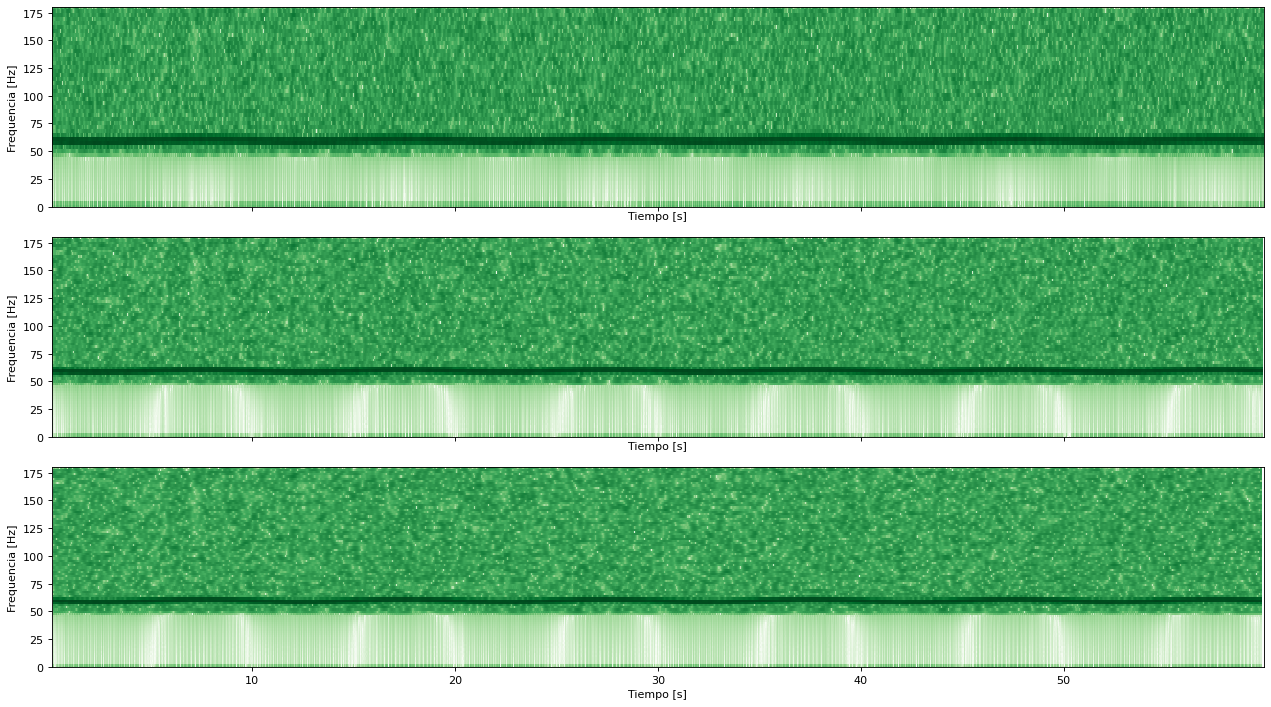

In [162]:
fig, axs1 = plt.subplots(3, 1, figsize=(16, 9), tight_layout=True, sharex=True, sharey=True)

#queremos probar en diferentes tamaños de ventana para sacar el valor que más nos sirve
for axs1, Nw in zip(axs1, [100, 150, 180]):
    fre, tim, Sx = scipy.signal.spectrogram(signal1, fs=Fs, window=('kaiser', beta), nperseg=Nw, noverlap=Nw//1.1)
    axs1.pcolormesh(tim, fre, np.log10(Sx+1e-10), cmap=plt.cm.Greens, shading='auto');
    axs1.set_ylabel('Frequencia [Hz]');
    axs1.set_xlabel('Tiempo [s]'); 
    axs1.set_ylim([0, 180]);

## Ruido 2

In [201]:
fc2,fc3 = 58.5,61.5 #frecuencia de corte ruido 2

q = [Figure(plot_width=600, plot_height=200, toolbar_location="below") for k1 in range(2)]

#filtro FIR para el Ruido 2
h2 = scipy.signal.firwin(numtaps=co, cutoff=[fc2,fc3], pass_zero=False, window='hamming',fs=Fs)
conv2 = scipy.signal.convolve(data, h2, mode='same', method='auto')
signal2 = data - conv2

freq_fir2, response_fir2 = scipy.signal.freqz(h2, 1, fs=Fs)
freq_fir2, delay_fir2 = scipy.signal.group_delay(system=(h2, 1), fs=Fs)

q[0].line(freq_fir2, np.absolute(response_fir2), color=palette[1], line_width=3, legend_label="FIR RUIDO 2"); 
q[1].line(freq_fir2, delay_fir2, color=palette[1], line_width=3, legend_label="FIR RUIDO 2"); 

q[1].xaxis.axis_label = 'Frecuencia [Hz]'
q[0].yaxis.axis_label = '|H|'
q[1].yaxis.axis_label = 'Desfase [º]'

show(column(q))

## Fourier sin Ruido 2

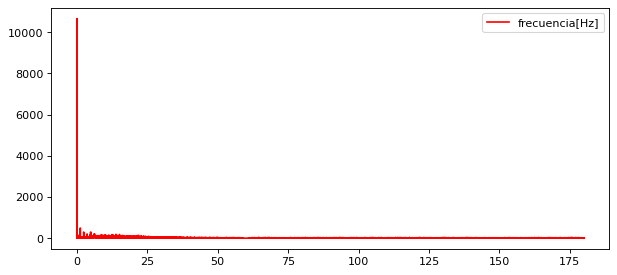

In [202]:
N2 = len(signal2)

fr2 = sfft.rfftfreq(n=N2, d=1./Fs)
S2 = np.absolute(sfft.rfft(signal2))

plt.figure(figsize=(9,4))
plt.plot(fr2, S2, 'r-')
plt.legend(('frecuencia[Hz]', 'S'))
plt.show()

## Espectrograma sin Ruido 2

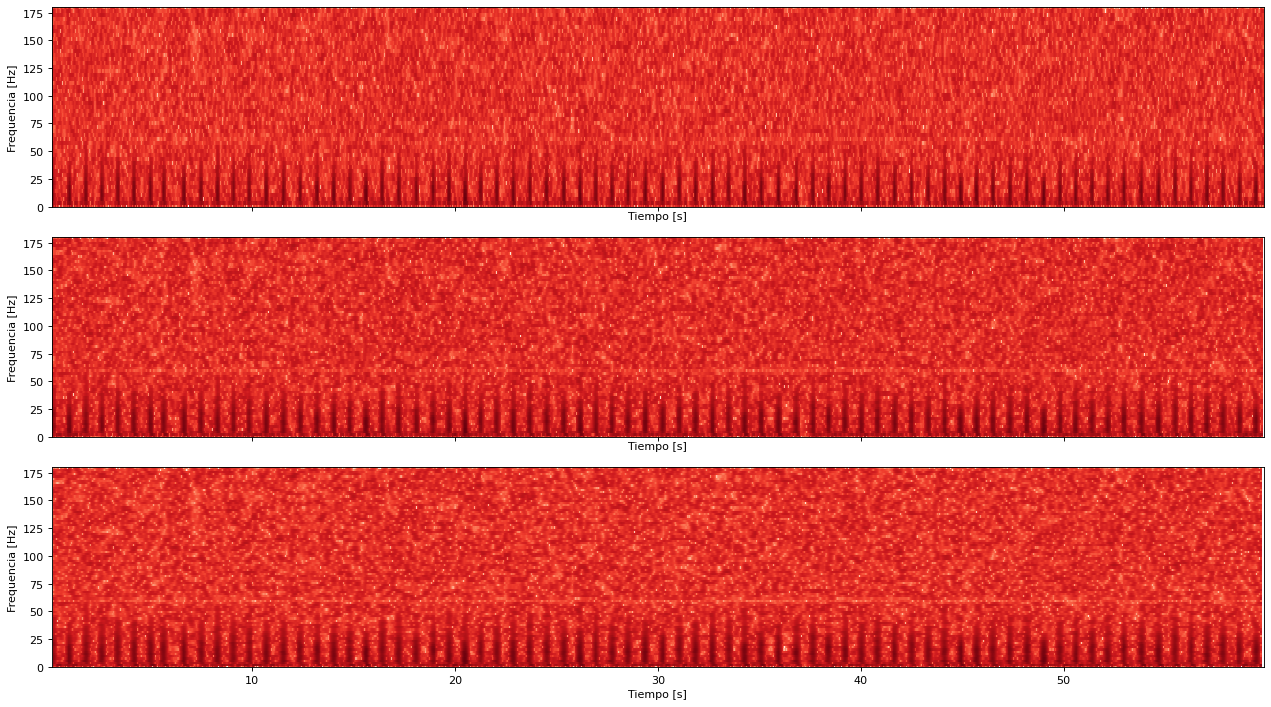

In [203]:
fig, axs2 = plt.subplots(3, 1, figsize=(16, 9), tight_layout=True, sharex=True, sharey=True)

#queremos probar en diferentes tamaños de ventana para sacar el valor que más nos sirve
for axs2, Nw in zip(axs2, [100, 150, 180]):
    fre, tim, Sx = scipy.signal.spectrogram(signal2, fs=Fs, window=('kaiser', beta), nperseg=Nw, noverlap=Nw//1.1)
    axs2.pcolormesh(tim, fre, np.log10(Sx+1e-10), cmap=plt.cm.Reds, shading='auto');
    axs2.set_ylabel('Frequencia [Hz]');
    axs2.set_xlabel('Tiempo [s]'); 
    axs2.set_ylim([0, 180]);

## Ruido 3

In [234]:
fc4,fc5 = 0.00001,179.99999 #frecuencia de corte ruido 3

r = [Figure(plot_width=600, plot_height=200, toolbar_location="below") for k1 in range(2)]

#filtro FIR para el Ruido 3
h3 = scipy.signal.firwin(numtaps=co, cutoff=[fc4,fc5], pass_zero=False, window='hamming',fs=Fs)
conv3 = scipy.signal.convolve(data, h3, mode='same', method='direct')
signal3 = data - conv3

freq_fir3, response_fir3 = scipy.signal.freqz(h3, fs=Fs)
freq_fir3, delay_fir3 = scipy.signal.group_delay(system=(h3, 1), fs=Fs)

r[0].line(freq_fir3, np.absolute(response_fir3), color=palette[2], line_width=3, legend_label="FIR RUIDO 3"); 
r[1].line(freq_fir3, delay_fir3, color=palette[2], line_width=3, legend_label="FIR RUIDO 3"); 

r[1].xaxis.axis_label = 'Frecuencia [Hz]'
r[0].yaxis.axis_label = '|H|'
r[1].yaxis.axis_label = 'Desfase [º]'

show(column(r))

## Fourier sin Ruido 3

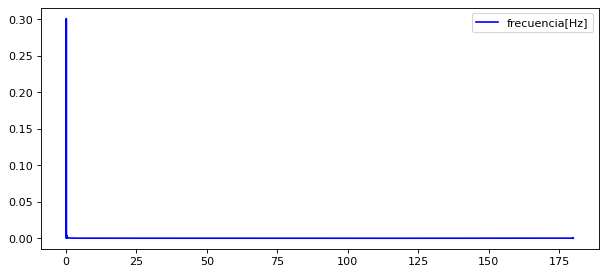

In [235]:
N3 = len(signal3)

fr3 = sfft.rfftfreq(n=N3, d=1./Fs)
S3 = np.absolute(sfft.rfft(signal3))

plt.figure(figsize=(9,4))
plt.plot(fr3, S3, 'b-')
plt.legend(('frecuencia[Hz]', 'S'))
plt.show()

## Espectrograma sin Ruido 3

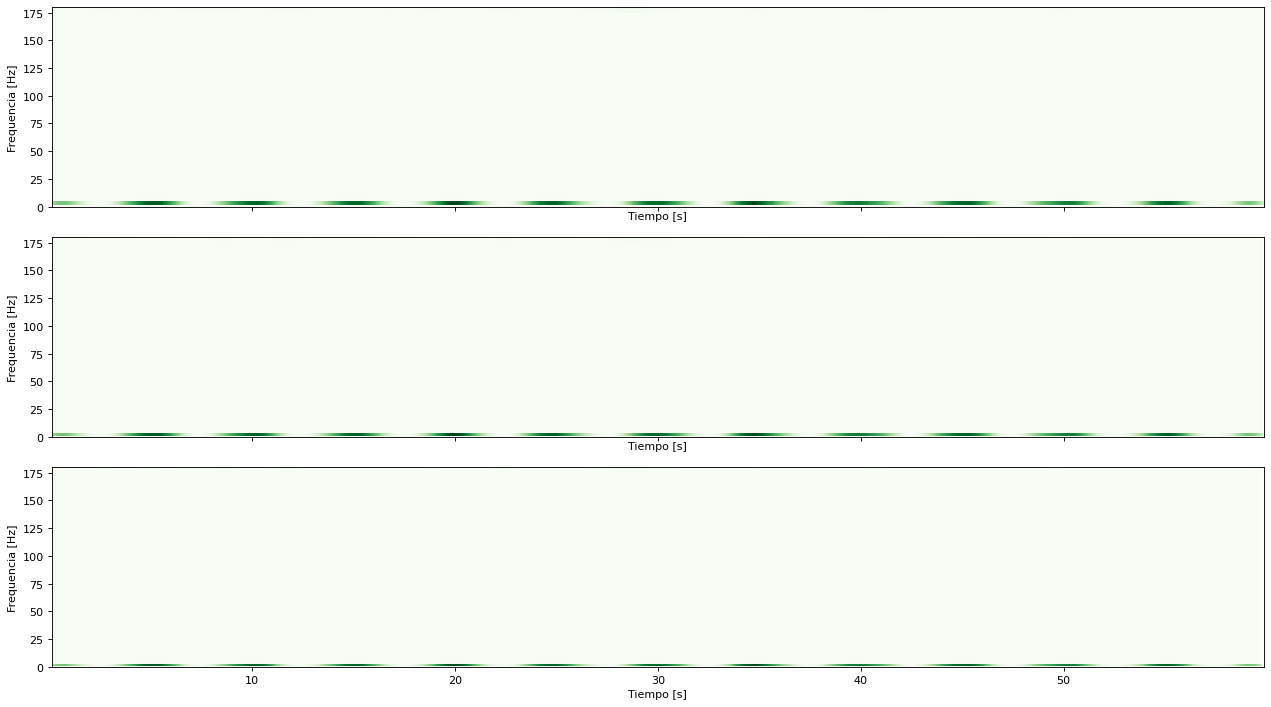

In [236]:
fig, axs3 = plt.subplots(3, 1, figsize=(16, 9), tight_layout=True, sharex=True, sharey=True)

#queremos probar en diferentes tamaños de ventana para sacar el valor que más nos sirve
for axs3, Nw in zip(axs3, [100, 150, 180]):
    fre, tim, Sx = scipy.signal.spectrogram(signal3, fs=Fs, window=('kaiser', beta), nperseg=Nw, noverlap=Nw//1.1)
    axs3.pcolormesh(tim, fre, np.log10(Sx+1e-10), cmap=plt.cm.Greens, shading='auto');
    axs3.set_ylabel('Frequencia [Hz]');
    axs3.set_xlabel('Tiempo [s]'); 
    axs3.set_ylim([0, 180]);

## Filtro con los 3 ruidos

In [259]:
h4 = scipy.signal.firwin(numtaps=co, cutoff=[fc4,fc1,fc2,fc3,fc5], pass_zero=False, window='hamming',fs=Fs)
conv4 = scipy.signal.convolve(data, h4, mode='same', method='auto')
signal4 = data - conv4

## Fourier sin los 3 filtros

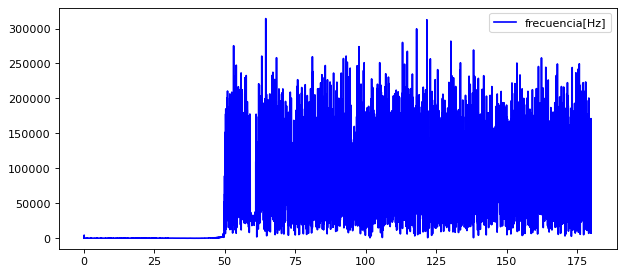

In [257]:
N4 = len(signal4)

fr4 = sfft.rfftfreq(n=N4, d=1./Fs)
S4 = np.absolute(sfft.rfft(signal4))

plt.figure(figsize=(9,4))
plt.plot(fr4, S4, 'b-')
plt.legend(('frecuencia[Hz]', 'S'))
plt.show()

## Espectrograma sin los 3 filtros

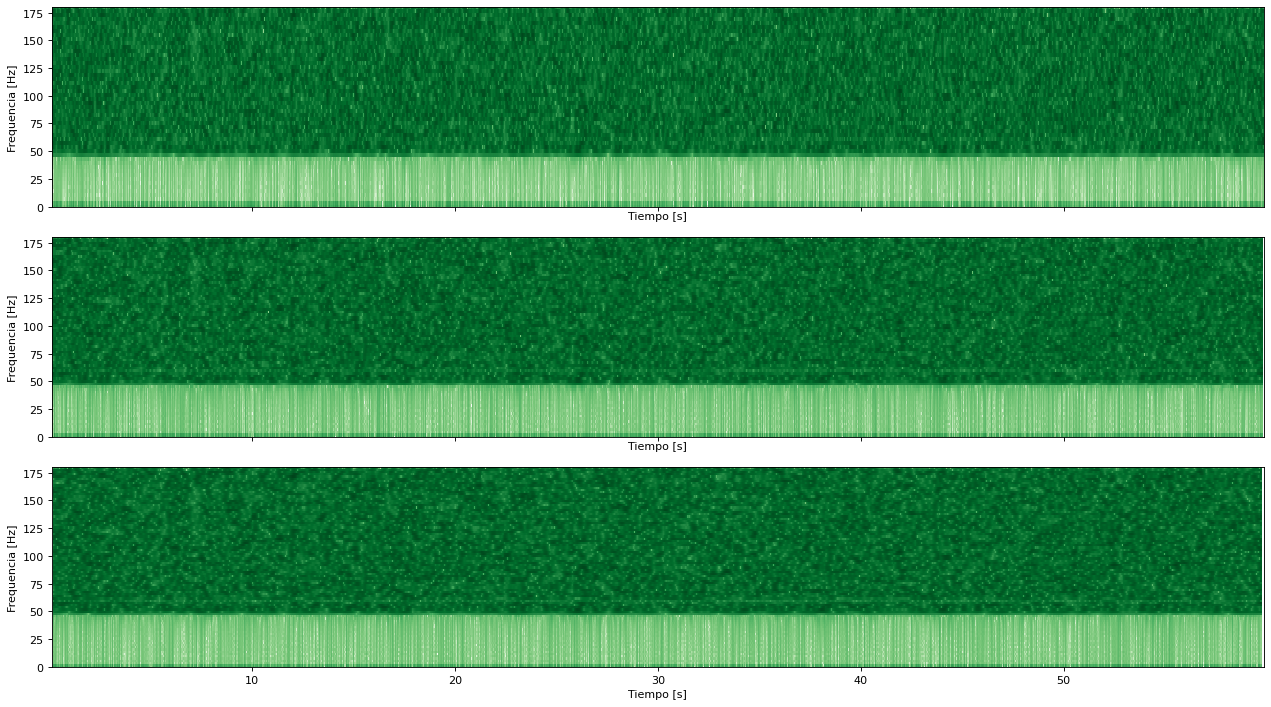

In [258]:
fig, axs4 = plt.subplots(3, 1, figsize=(16, 9), tight_layout=True, sharex=True, sharey=True)

#queremos probar en diferentes tamaños de ventana para sacar el valor que más nos sirve
for axs4, Nw in zip(axs4, [100, 150, 180]):
    fre, tim, Sx = scipy.signal.spectrogram(signal4, fs=Fs, window=('kaiser', beta), nperseg=Nw, noverlap=Nw//1.1)
    axs4.pcolormesh(tim, fre, np.log10(Sx+1e-10), cmap=plt.cm.Greens, shading='auto');
    axs4.set_ylabel('Frequencia [Hz]');
    axs4.set_xlabel('Tiempo [s]'); 
    axs4.set_ylim([0, 180]);

## Cálculo

## Filtrado IIR (35%)

Describa los filtros IIR y compárelo con los filtros FIR. Describa los argumentos y el valor de retorno de la función `scipy.signal.iirfilter`.

Luego use este método para diseñar tres filtros. Los filtros deben cumplir el mismo propósito que en el caso anterior. Considere filtros IIR de tipo `butterworth` y todos del mismo orden. Aplique los filtros sobre la señal de entrada usando la función `scipy.signal.lfilter`.

El objetivo es encontrar el mínimo orden para los filtros IIR tal que el error medio cuadrático entre la señal filtrada IIR y la señal filtrada FIR sea menor que un 1% de la varianza de la señal filtrada FIR. Es decir que si $x$ es la señal filtrada IIR e $y$ es la señal filtrada FIR donde $N = \min(\text{len}(x), \text{len}(y))$ se cumpla que

$$
\sum_{i=1}^N (x_i - y_i)^2 < 0.01 \sum_{i=1}^N (y_i - \bar y_i)^2
$$

Finalmente, discuta sobre sus hallazgos muestre gráficamente el resultado del mejor filtro IIR
